# BPDA attack

Description: Implement BPDA attack against Defense-GAN as proposed in the paper [Obfuscated Gradients Give a False Sense of Security: Circumventing Defenses to Adversarial Examples](https://https://arxiv.org/abs/1802.00420)

## Setup

In [0]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from IPython import display

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [0]:
# Normalize the images to [0, 1]
x_train = x_train/255.0
x_train = x_train.astype('float32')
x_test = x_test/255.0
x_test = x_test.astype('float32')

## CNN (use original training data `x_train`)

In [0]:
model_org = models.Sequential()
model_org.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_org.add(layers.MaxPooling2D((2, 2)))
model_org.add(layers.BatchNormalization())
model_org.add(layers.Dropout(0.2))

model_org.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_org.add(layers.MaxPooling2D((2, 2)))
model_org.add(layers.BatchNormalization())
model_org.add(layers.Dropout(0.2))

model_org.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_org.add(layers.BatchNormalization())
model_org.add(layers.Flatten())
model_org.add(layers.Dense(64, activation='relu'))
model_org.add(layers.Dense(10))

In [0]:
model_org.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model_org.fit(x_train, y_train, epochs=8, 
                    validation_data=(x_test, y_test))

Epoch 1/8
1563/1563 [==============================] - 12s 8ms/step - loss: 1.3875 - accuracy: 0.5114 - val_loss: 1.3834 - val_accuracy: 0.5341
Epoch 2/8
1563/1563 [==============================] - 12s 8ms/step - loss: 0.9956 - accuracy: 0.6481 - val_loss: 1.6410 - val_accuracy: 0.5009
Epoch 3/8
1563/1563 [==============================] - 12s 8ms/step - loss: 0.8451 - accuracy: 0.7024 - val_loss: 1.0455 - val_accuracy: 0.6545
Epoch 4/8
1563/1563 [==============================] - 12s 8ms/step - loss: 0.7537 - accuracy: 0.7355 - val_loss: 0.9320 - val_accuracy: 0.6875
Epoch 5/8
1563/1563 [==============================] - 12s 8ms/step - loss: 0.6800 - accuracy: 0.7617 - val_loss: 0.8728 - val_accuracy: 0.7052
Epoch 6/8
1563/1563 [==============================] - 12s 8ms/step - loss: 0.6240 - accuracy: 0.7799 - val_loss: 0.7954 - val_accuracy: 0.7315
Epoch 7/8
1563/1563 [==============================] - 12s 8ms/step - loss: 0.5756 - accuracy: 0.7953 - val_loss: 1.4003 - val_accuracy:

## CNN (use generated training data `gen_train`)

In [0]:
gen_train = np.load('/content/drive/My Drive/Colab Notebooks/Defense-GAN/data/gen_train.npy')

In [0]:
model_rec = models.Sequential()
model_rec.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_rec.add(layers.MaxPooling2D((2, 2)))
model_rec.add(layers.BatchNormalization())
model_rec.add(layers.Dropout(0.2))

model_rec.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_rec.add(layers.MaxPooling2D((2, 2)))
model_rec.add(layers.BatchNormalization())
model_rec.add(layers.Dropout(0.2))

model_rec.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_rec.add(layers.MaxPooling2D((2, 2)))
model_rec.add(layers.BatchNormalization())
model_rec.add(layers.Flatten())
model_rec.add(layers.Dense(64, activation='relu'))
model_rec.add(layers.Dense(10))

In [0]:
model_rec.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model_rec.fit(gen_train, y_train, epochs=10, 
                    validation_data=(x_test, y_test))

Epoch 1/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.6585 - accuracy: 0.4078 - val_loss: 1.4787 - val_accuracy: 0.4678
Epoch 2/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.4581 - accuracy: 0.4735 - val_loss: 1.3505 - val_accuracy: 0.5166
Epoch 3/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.3902 - accuracy: 0.5011 - val_loss: 1.3260 - val_accuracy: 0.5323
Epoch 4/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.3374 - accuracy: 0.5204 - val_loss: 1.2989 - val_accuracy: 0.5351
Epoch 5/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.2965 - accuracy: 0.5343 - val_loss: 1.2784 - val_accuracy: 0.5537
Epoch 6/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.2573 - accuracy: 0.5485 - val_loss: 1.1962 - val_accuracy: 0.5842
Epoch 7/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.2229 - accuracy: 0.5619 - val_loss: 1.2665 - val_ac

## BPDA attack

Reference: https://github.com/anishathalye/obfuscated-gradients/blob/master/defensegan/l2_attack.py

In [0]:
@tf.function
def attack(model, generator, noise, image, label, targeted=None, num_classes=10, const=1, confidence=0, learning_rate=0.004, step=200):
  '''
  attack a single image

  model: image classifier
  generator: generator of defense-gan
  noise: input of the generator
  image: image to attack
  label: true label
  targeted: targeted attack or not
  num_classes: #classes in the dataset
  const: larger const indicates lower accuracy but further from original image
  confidence: larger confidence indicates lower accuracy but further from original image
  learning_rate: learning rate of gradient descent
  step: number of gradient descent steps
  '''
  loss_object = tf.keras.losses.CategoricalCrossentropy()

  label_prob = tf.one_hot(label, num_classes)[0]
  if targeted is None:
    target = label_prob
  else:
    target = targeted

  for i in range(step):
    with tf.GradientTape() as tape:
      tape.watch(noise)
      fake = generator(noise, training=False)
      loss1 = tf.reduce_sum((fake - image)**2, axis=[1,2,3])

      pred = model(fake, training=False)
      if targeted is None:
        loss2 = tf.maximum(0.0, loss_object(label_prob, pred) - loss_object(target, pred) + confidence)
      else:
        loss2 = tf.maximum(0.0, loss_object(target, pred) - loss_object(label_prob, pred) + confidence)

      loss = loss1 + loss2 * const
    
    gradients = tape.gradient(loss, noise)
    noise.assign_sub(learning_rate * gradients)
    
  idx = tf.argmin(loss, axis=0)
  noise = tf.reshape(noise[idx], (1, -1))
  return generator(noise, training=False)

In [0]:
def attack_batch(model, generator, images, label, targeted=None, num_classes=10, const=1, confidence=0, learning_rate=0.004, step=200):
  '''
  attack a batch of images

  model: image classifier
  generator: generator of defense-gan
  images: images to attack
  label: true labels
  targeted: targeted attack or not
  num_classes: #classes in the dataset
  const: larger const indicates lower accuracy but further from original image
  confidence: larger confidence indicates lower accuracy but further from original image
  learning_rate: learning rate of gradient descent
  step: number of gradient descent steps
  '''

  predictions = []
  start=time.time()
  for i in range(images.shape[0]):
    noise = tf.random.normal([1, 128])
    noise = tf.Variable(noise, trainable=True)
    if targeted is None:
      target = None
    else:
      target = targeted[i:i+1]
    predictions.append(attack(model, generator, noise, images[i:i+1], label[i:i+1], 
                              target, num_classes, const, 
                              confidence, learning_rate, step))
    # record progress
    display.clear_output(wait=True)
    if (i+1)%10 == 0:
      print('Batch: {}/{}\tTime: {} sec'.format(i+1, images.shape[0], time.time()-start))
      start=time.time()
  return tf.concat(predictions, axis=0)

In [0]:
target = tf.squeeze(tf.one_hot(y_test, 10))
prediction = model_org(x_test, training=False)
prediction -= target * 1000
target = tf.argmax(prediction, axis=1)
target = tf.one_hot(target, 10)

In [0]:
%%time
x = attack_batch(model_org, generator, x_test, y_test, 
                targeted=target, num_classes=10, 
                const=1.5, confidence=0, 
                learning_rate=0.004, step=200)

In [0]:
np.save('/content/drive/My Drive/Colab Notebooks/Defense-GAN/data/bpda_test.npy', x)

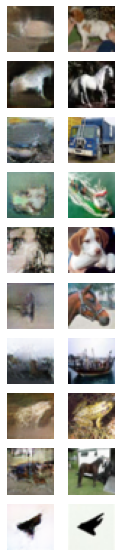

In [0]:
# samples of perturbed images
plt.figure(figsize=(2,10))
for i in range(1, 11):
  plt.subplot(10, 2, 2*i-1)
  plt.imshow(x[i+11])
  plt.axis('off')
  plt.subplot(10, 2, 2*i)
  plt.imshow(x_test[i+11])
  plt.axis('off')

In [0]:
#x = np.load('/content/drive/My Drive/Colab Notebooks/Defense-GAN/data/bpda_test.npy')

## Defense-GAN

In [0]:
!unzip wgan

In [0]:
generator = models.load_model('wgan')

In [0]:
# use WGAN-GP to generate an image that is closest to the original one
@tf.function
def search(noise, image, learning_rate=0.004, step=200):
  for i in range(step):
    with tf.GradientTape() as tape:
      tape.watch(noise)
      fake = generator(noise, training=False)
      loss = tf.reduce_sum((fake - image)**2, axis=[1,2,3])
    
    gradients = tape.gradient(loss, noise)
    noise.assign_sub(learning_rate * gradients)
    
  idx = tf.argmin(loss, axis=0)
  noise = tf.reshape(noise[idx], (1, -1))
  return generator(noise, training=False)

In [0]:
# `search()` only deals with one image, while this function deals with multiple images
def search_batch(images, learning_rate=0.004, step=200):
  predictions = []
  start=time.time()
  for i in range(images.shape[0]):
    noise = tf.random.normal([10, 128])
    noise = tf.Variable(noise, trainable=True)
    predictions.append(search(noise, images[i], learning_rate, step))
    # record progress
    display.clear_output(wait=True)
    if (i+1)%10 == 0:
      print('Batch: {}/{}\tTime: {} sec'.format(i+1, images.shape[0], time.time()-start))
      start=time.time()
  return tf.concat(predictions, axis=0)

In [0]:
%%time
gen_x = search_batch(x, step=200)

In [0]:
np.save('/content/drive/My Drive/Colab Notebooks/Defense-GAN/data/bpda_gen_test.npy', gen_x)

In [0]:
#gen_x = np.load('/content/drive/My Drive/Colab Notebooks/Defense-GAN/data/bpda_gen_test.npy')

In [0]:
# BPDA attack + defense-gan-org
model_org.evaluate(gen_x, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 2.9721 - accuracy: 0.2880


[2.9720778465270996, 0.2879999876022339]

In [0]:
# BPDA attack + defense-gan-rec
model_rec.evaluate(gen_x, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.8796 - accuracy: 0.3873


[1.8796466588974, 0.3873000144958496]

## Results

Accuracy:
- FGSM attack + defense-gan-org: ~40%
- BPDA attack + defense-gan-org: ~28%


- FGSM attack + defense-gan-rec: ~52%
- BPDA attack + defense-gan-rec: ~38%